In [1]:
# 1. Install packages
!pip install torch nltk scikit-learn pandas matplotlib

In [2]:
# 2. Import libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




In [3]:
# 3. Load dataset
df = pd.read_csv('review_20242025_standard.csv')
df = df[['review', 'sentiment']].dropna()
df.head()

review  sentiment
0  "\"The Classic War of the Worlds\" by Timothy ...          1
1  "The film starts with a manager (Nicholas Bell...          0
2  "Superbly trashy and wondrously unpretentious ...          1
3  "I dont know why people think this is such a b...          1
4  "This movie could have been very good, but com...          0

In [4]:
# 4. Text preprocessing
# Define a tokenizer that also lowercases the text
def simple_tokenizer(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text.lower())
    else:
        return []



In [5]:
# 5. Tokenize text

# Apply the tokenizer directly
df['tokens'] = df['review'].apply(simple_tokenizer)

# View results
print(df[['review', 'tokens']].head())

                                              review  \
0  "\"The Classic War of the Worlds\" by Timothy ...   
1  "The film starts with a manager (Nicholas Bell...   
2  "Superbly trashy and wondrously unpretentious ...   
3  "I dont know why people think this is such a b...   
4  "This movie could have been very good, but com...   

                                              tokens  
0  [the, classic, war, of, the, worlds, by, timot...  
1  [the, film, starts, with, a, manager, nicholas...  
2  [superbly, trashy, and, wondrously, unpretenti...  
3  [i, dont, know, why, people, think, this, is, ...  
4  [this, movie, could, have, been, very, good, b...  


In [6]:
# 6. Build vocabulary from training data
from collections import Counter

all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}  # start from 2
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [7]:
# 7. Encode tokens into integers
def encode_tokens(tokens):
    return [vocab.get(token, 1) for token in tokens]  # 1 is <UNK>

df['encoded'] = df['tokens'].apply(encode_tokens)

In [8]:
# 8. Pad sequences
from torch.nn.utils.rnn import pad_sequence

max_len = 600

def pad_seq(seq):
    return seq[:max_len] + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

df['padded'] = df['encoded'].apply(pad_seq)

In [9]:
# 9. Initialize random embeddings
embedding_dim = 300


In [10]:
# 10. Create Dataset and Dataloader (unchanged)
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

# Split
X_train, X_test, y_train, y_test = train_test_split(df['padded'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=33245215)
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        lstm_out, (hidden, _) = self.lstm(embedded)

        # hidden is [num_layers * num_directions, batch, hidden_dim]
        # Concatenate the final forward and backward hidden states
        hidden_fw = hidden[-2, :, :]  # forward
        hidden_bw = hidden[-1, :, :]  # backward
        hidden_cat = torch.cat((hidden_fw, hidden_bw), dim=1)

        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return self.sigmoid(output).squeeze(1)  # [batch_size]




In [12]:
# 12. Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(len(vocab), 
                  embedding_dim=embedding_dim, 
                  hidden_dim=128, 
                  output_dim=1).to(device)




In [13]:
# 13. Train the model
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6372
Epoch 2, Loss: 0.5064
Epoch 3, Loss: 0.4042
Epoch 4, Loss: 0.2852
Epoch 5, Loss: 0.2219


In [14]:
# 14. Evaluate
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        preds = (outputs >= 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())


In [15]:
# 15. Report
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.8268
Confusion Matrix:
 [[1604  468]
 [ 264 1890]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.77      0.81      2072
         1.0       0.80      0.88      0.84      2154

    accuracy                           0.83      4226
   macro avg       0.83      0.83      0.83      4226
weighted avg       0.83      0.83      0.83      4226



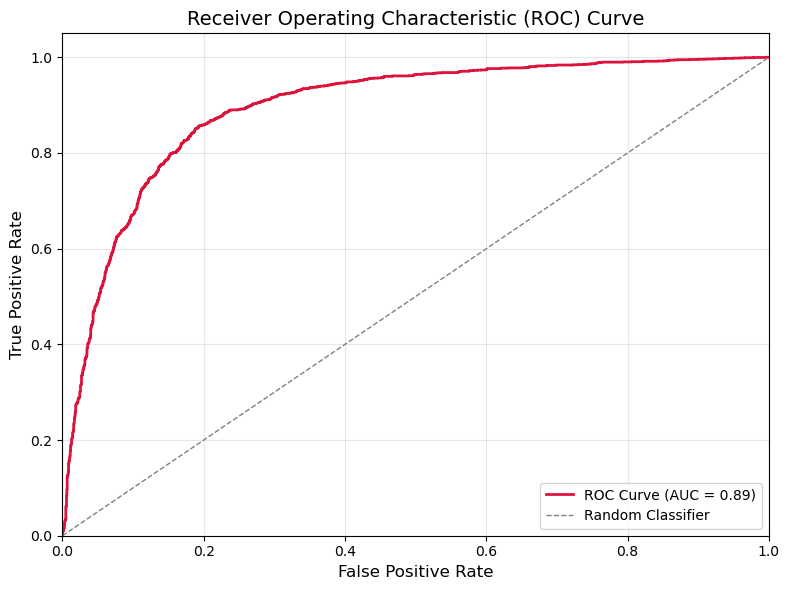

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
model.eval()
y_true = []
y_scores2 = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()  # sigmoid probabilities
        y_scores2.extend(outputs)
        y_true.extend(labels.numpy())

# Compute ROC curve and AUC
fpr_2, tpr_2, thresholds = roc_curve(y_true, y_scores2)
roc_auc = auc(fpr_2, tpr_2)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_2, tpr_2, color='crimson', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

np.save("y_true_model2.npy", y_true)
np.save("y_scores_model2.npy", y_scores2)



In [17]:
# 16. Predict sentiment for a new review
def preprocess_and_encode(text, vocab, max_len=100):
    tokens = re.findall(r'\b\w+\b', text.lower())
    encoded = [vocab.get(token, 1) for token in tokens]  # 1 is <UNK>
    padded = encoded[:max_len] + [0] * (max_len - len(encoded)) if len(encoded) < max_len else encoded[:max_len]
    return torch.tensor(padded, dtype=torch.long).unsqueeze(0)  # Add batch dimension

def predict_sentiment(text):
    model.eval()
    input_tensor = preprocess_and_encode(text, vocab).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = int(output.item() >= 0.5)
        return "Positive" if pred == 1 else "Negative"

# Example usage
example_text = "This movie could have been very good "
print("Sentiment:", predict_sentiment(example_text))

# Example usage
example_text = "This movie could have been very bad "
print("Sentiment:", predict_sentiment(example_text))

Sentiment: Negative
Sentiment: Negative
